In [220]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import shutil
from torchvision import datasets
from torchvision.io import read_image
import pandas as pd
import matplotlib.pyplot as plt
import math
import PIL
import seaborn as sns

In [221]:
#shuffle ints [1,1000] and split into train/val/test with 80/10/10 split
def shuffle_split():
    #shuffle ints [1,1000]
    ints = np.arange(1,1001)
    np.random.shuffle(ints)
    #split into train/val/test with 80/10/10 split
    train = ints[:800]
    val = ints[800:900]
    test = ints[900:]
    return train, val, test

In [222]:
train, val, test = shuffle_split()

In [223]:
source = "./aloi_red4_col/png4/"
target = "./data_split/"

if (not os.path.exists(target)):
    os.mkdir(target)

In [224]:
#copy files into train/val/test based on split
if (not os.path.exists(target + "train") and not os.path.exists(target + "val") and not os.path.exists(target + "test")):
    os.mkdir(target + "train")
    os.mkdir(target + "val")
    os.mkdir(target + "test")
    for file in os.listdir(source):
        if (int(file) in train):
            for files in os.listdir(source + file):
                shutil.copy(source + file + "/" + files, target + "train/" + files)
        elif (int(file) in val):
            for files in os.listdir(source + file):
                shutil.copy(source + file + "/" + files, target + "val/" + files)
        elif (int(file) in test):
            for files in os.listdir(source + file):
                shutil.copy(source + file + "/" + files, target + "test/" + files)

In [225]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(os.listdir(self.root_dir))
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        image = image.float()
        material_name = self.annotations.iloc[index, 1]
        y_label = torch.tensor(self.label[material_name])
        return (image, y_label)

In [226]:
material_label = {"plastic": 0, "metal": 1,"paper": 2, "wood": 3, "other": 4}

In [227]:
Top4Dataset_Train = Top4Dataset(csv_file = "./top4_materials.csv", root_dir = "./data_split/train", label= material_label)
Top4Dataset_Val = Top4Dataset(csv_file = "./top4_materials.csv", root_dir = "./data_split/val", label= material_label)
Top4Dataset_Test = Top4Dataset(csv_file = "./top4_materials.csv", root_dir = "./data_split/test", label= material_label)


In [228]:
DataLoader_Train = DataLoader(dataset = Top4Dataset_Train, batch_size = 16, shuffle = True)
DataLoader_Val = DataLoader(dataset = Top4Dataset_Val, batch_size = 16, shuffle = True)
DataLoader_Test = DataLoader(dataset = Top4Dataset_Test, batch_size = 16, shuffle = True)

In [229]:
for images, labels in DataLoader_Train:
    print(images.shape)
    print(labels.shape)
    break
len(DataLoader_Train.dataset)

torch.Size([16, 3, 144, 192])
torch.Size([16])


9600

In [230]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #3 input image channel, 6 output channels, 5x5 square convolution with 0 padding
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.Conv2d(6, 16, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*64*88, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 5),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        logits = self.linear_relu_stack(logits)
        return logits

model = ConvNeuralNetwork().to(device)
print(model)

Using cuda device
ConvNeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=180224, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): Linear(in_features=256, out_features=5, bias=True)
    (6): LogSoftmax(dim=1)
  )
)


In [231]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_result = 0
    for batch, (X, y) in enumerate(dataloader):
        # add noise to the image
        # Compute prediction error
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_result += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_result/len(dataloader)

In [232]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [233]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [234]:
#model parameters
learning_rate = 1e-3
epochs = 100
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [235]:
#train model
early_stopping = EarlyStopper()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(DataLoader_Train, model, loss_fn, optimizer)
    test_loss = test(DataLoader_Test, model, loss_fn)
    if early_stopping.early_stop(test_loss):
        print("Early stopping")
        break
print("Done!")

Epoch 1
-------------------------------
loss: 1.971334  [    0/ 9600]
loss: 1.116370  [ 1600/ 9600]
loss: 0.794897  [ 3200/ 9600]
loss: 0.560242  [ 4800/ 9600]
loss: 0.779354  [ 6400/ 9600]
loss: 0.122206  [ 8000/ 9600]
Test Error: 
 Accuracy: 44.2%, Avg loss: 2.114577 

Epoch 2
-------------------------------
loss: 0.156945  [    0/ 9600]
loss: 0.033388  [ 1600/ 9600]
loss: 0.017221  [ 3200/ 9600]
loss: 0.066246  [ 4800/ 9600]
loss: 0.012286  [ 6400/ 9600]
loss: 0.001119  [ 8000/ 9600]
Test Error: 
 Accuracy: 38.2%, Avg loss: 4.127363 

Early stopping
Done!


In [236]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    xb = xb.to(device)
    xb = xb.float()
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [237]:
test_image_path = "./data_split/val/13_i190.png"
img_name = test_image_path.split("/")[-1]
test_image = read_image(test_image_path)

shower = plt.imread(test_image_path)
plt.imshow(shower)


RuntimeError: [Errno 2] No such file or directory: './data_split/val/13_i190.png'

In [ ]:

# function to return key for any value
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

In [ ]:
result = predict_image(test_image, model)
result_label = get_key(result, material_label)

actual_label_table = pd.read_csv("./top4_materials.csv")
actual_label = actual_label_table[actual_label_table["name_img"] == img_name]["material"].values[0]
print(f"Predicted class: {result_label,result}")
print(f"Actual class: {actual_label}")


Predicted class: ('plastic', 0)
Actual class: paper


In [ ]:
def confusionMatrix(model, dataloader):
    confusion_matrix = torch.zeros(5, 5)
    with torch.no_grad():
        total = 0
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix

In [ ]:
confusion_matrix = confusionMatrix(model, DataLoader_Test)

In [ ]:
confusion_matrix

tensor([[118.,  23.,   0.,  22., 245.],
        [  0.,   0.,   0.,  12.,  12.],
        [ 36.,   0.,  14.,   0.,  10.],
        [ 34.,   9.,  12.,   0.,  65.],
        [199.,  15.,  25.,  59., 290.]])

In [ ]:
material_label

{'plastic': 0, 'metal': 1, 'paper': 2, 'wood': 3, 'other': 4}

Text(0.5, 1.0, 'Confusion matrix')

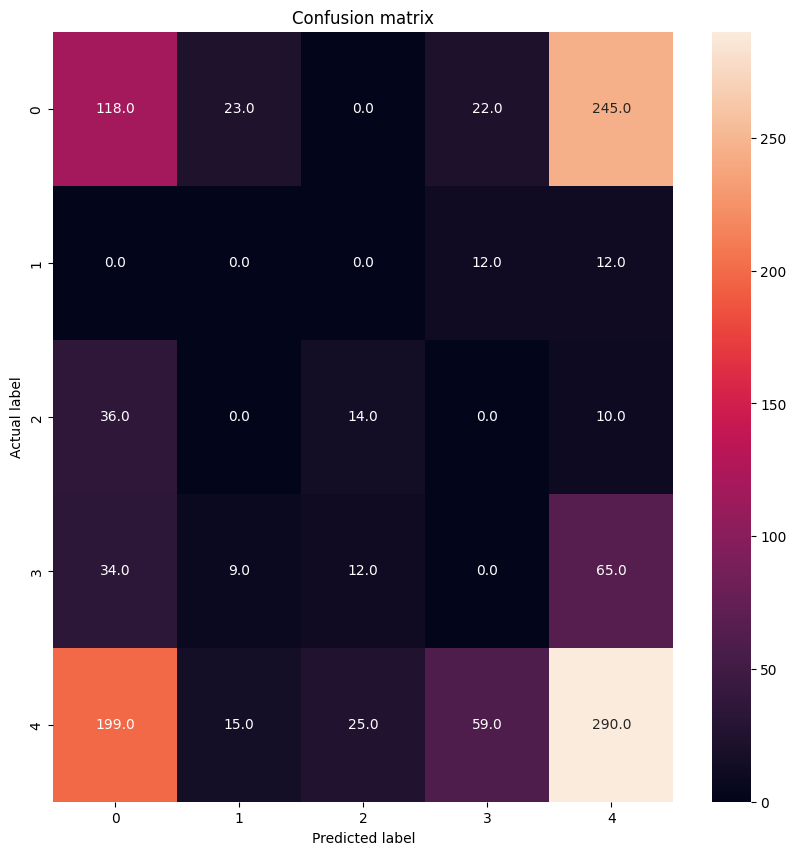

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix")

In [ ]:
random = torch.rand(3,144, 192)
conv1 = nn.Conv2d(3, 6, 5)
conv2 = nn.Conv2d(6, 16, 5)
conv3 = nn.Conv2d(16, 32, 5)
pool = nn.MaxPool2d(5, 2)

out = conv1(random)
out = conv2(out)
out = conv3(out)
out = pool(out)
out.shape

torch.Size([32, 64, 88])